In [1]:
import rioxarray as rxr
import matplotlib.pyplot as plt
from working_sca_funcs import create_binary_chm, extract_dates, closest_date
import geopandas as gpd
import numpy as np
from scipy.signal import convolve2d
import glob
import os
import pandas as pd
from working_sca_funcs import calc_rgb,create_ps_df, create_aso_df
import xarray as xr
from datetime import datetime
import rasterio as rio
import netCDF4

In [2]:
# Basin, Model Run, Year
name = 'COPP'
model = 'base'
year = 2022
# EPSG = 'EPSG:32611'
EPSG= 'EPSG:26913'
# Basin shapefile
BS = f'/home/etboud/projects/data/basins/{name}/{name}_4326.geojson'
# BS = '/home/etboud/projects/snow_mapping/Emma/budd_rectangle_modis_extent_4326_b200.geojson'
basin = gpd.read_file(BS)
basin = basin.to_crs(EPSG) 

rgi = '/home/etboud/projects/data/RGI/02_rgi60_WesternCanadaUS/02_rgi60_WesternCanadaUS.shp'
rgi_mask = gpd.read_file(rgi).to_crs(EPSG)
wbd = '/home/etboud/projects/data/masks/NHDWaterbody.shp'
wbd_mask = gpd.read_file(wbd).to_crs(EPSG)

# raw PS images
#ps_raw = f'/data0/images/planet/emma/planet/{name}/'
ps_raw = '/home/etboud/projects/data/planet/{name}/'
ps_raw_subdir = sorted([d for d in glob.glob(ps_raw + str(year) + '*') if os.path.isdir(d)])

# # Processed PS SCA
# ps_sca_dir = f'/data0/images/planet/emma/planet/processed_SCA/{name}/{model}/'
# ps_sca_tif = glob.glob(ps_sca_dir + f'*{year}*.tif')

# # ASO SCA
# aso_dir = f'/home/etboud/projects/data/aso/validation/{name}/V2/'
# aso_tif = glob.glob(aso_dir + f'*{year}*3m*.tif')

# # Extract dates from file names
# ps_dates = extract_dates([], ps_sca_tif)[1]  
# aso_dates = extract_dates(aso_tif, [])[0]

starting_value = 0

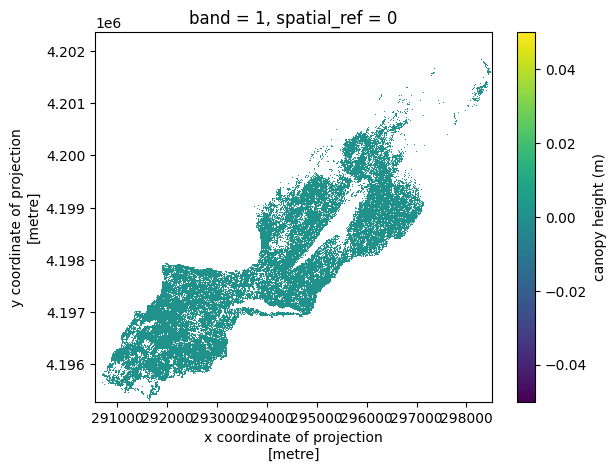

In [3]:
# canopy height model
CHM = '/home/etboud/projects/data/CHM/USCATB20140827_chm_3p0m.tif'
chm_mask, mean, max, fcan = create_binary_chm(CHM, basin)
chm_mask.values= np.where(chm_mask.values==1, np.nan, chm_mask.values)
chm_mask.plot()


# save chm mask 
# save chm mask
# chm_mask = chm_mask.rio.set_crs('EPSG:32611')
# chm_mask = chm_mask.rio.write_crs('EPSG:32611', inplace=True)
# chm_mask = chm_mask.rio.set_spatial_dims(x_dim='x', y_dim='y')
# chm_mask = chm_mask.rio.set_nodata(np.nan)
# chm_mask.rio.to_raster(f'/home/etboud/projects/data/CHM/{name}_CHM_mask.tif', driver='GTiff')


In [5]:
def fill_nodata(stacked_data):
    t,y,x = stacked_data.shape
    for tt in np.arange(t):
        tt_date = stacked_data[tt,:,:]
        if tt == 0: # For the first time step, any value of 2 is set to 1
            tt_date[tt_date == 2] = 1
        else: # For following timesteps, any value of 2 is set to the value of the previous timestep
            tt_ref = stacked_data[tt-1,:,:]
            tt_date[tt_date == 2] = tt_ref[tt_date == 2] 
        stacked_data[tt,:,:] = tt_date
    return stacked_data


# 4 band PlanetScope data
# --------------NDVI INCLUDED------------------
# function for classifying snow cover using "model"
def run_ndvi_calculation(fname, basin, rgi_mask, wbd_mask):
        
    ds = rxr.open_rasterio(fname, crs = 'EPSG:32611')
    ds.values = np.where(np.isnan(ds.values), 0, ds.values)
    # ds = ds.rio.clip(basin.geometry.values, basin.crs)
    ds = ds.rio.clip(rgi_mask.geometry,invert=True) #testing
    ds = ds.rio.clip(wbd_mask.geometry,invert=True) #testing
    print(ds.shape)
    arr = ds.values
    arr_sum = np.sum(arr,axis=0)
        
    # Extract the bands
    # blue = arr[0, :, :]
    # green = arr[1, :, :]
    red = arr[2, :, :]
    nir = arr[3, :, :]
    
    # Calculate NDVI
    ndvi = (nir - red) / (nir + red)

    return ndvi

In [ ]:
# # 8 band PlanetScope data``
# # --------------RTVI INCLUDED------------------
# # function for classifying snow cover using "model"
# def run_rtvi_calculation(fname, basin, rgi_mask, wbd_mask):
        
#     ds = rxr.open_rasterio(fname, crs = 'EPSG:32611')
#     ds.values = np.where(np.isnan(ds.values), 0, ds.values)
#     ds = ds.rio.clip(basin.geometry.values, basin.crs)
#     ds = ds.rio.clip(rgi_mask.geometry,invert=True) #testing
#     ds = ds.rio.clip(wbd_mask.geometry,invert=True) #testing
#     arr = ds.values
#     arr_sum = np.sum(arr,axis=0)
        
#     # Extract the bands
#     # blue = arr[1, :, :]
#     green = arr[3, :, :]
#     red = arr[5, :, :]
#     red_edge = arr[6, :, :]
#     nir = arr[7, :, :]
    
#     # Calculate NDVI
#     ndvi = (nir - red) / (nir + red)
#     rtvi = (100*(nir-red_edge)-10*(nir-green))
#     return ndvi, rtvi

# 4 Band processing

In [6]:
data_direc = f'/data0/images/planet/emma/planet/{name}/'
# specify the directories and the indices of which PS scenes to filter, if any
subdirecs = sorted([d for d in glob.glob(data_direc + str(year) + '*') if os.path.isdir(d)])[-15:]

# FOr NDVI 4 band processing
ref_date = datetime(year - 1, 10, 1).date()
ndvi_list = []
# rtvi_list = []
for dCount,direcc in enumerate(subdirecs):
        fname = glob.glob(direcc+'/*/PSScene/*SR_clip.tif')[0]
        ndvi_arr = run_ndvi_calculation(fname, basin, rgi_mask, wbd_mask)
        # Check if the shape is (4, 1627, 914) for BUDD and (2361, 2650) for DLNY, for not clipped DLNY (2426, 2716), rect unclipped budd ( 1971, 1316 or 18)
        if ndvi_arr.shape == (2305, 2441):
                ndvi_list.append(ndvi_arr)
                


# Create a stacked data array for snow cover
stacked_ndvi = np.stack(ndvi_list, axis=0).astype(float)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2305, 2441)


/tmp/ipykernel_3768693/3898295849.py:35: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


In [7]:

# filin in missing values and create mean composite of NDVI for 4 band 
# canopy is np.where((ndvi_mean > 0.45) & (ndvi_mean < 0.85), ndvi_mean, np.nan)
fill_stacked_ndvi = fill_nodata(stacked_ndvi)
ndvi_mean = np.nanmean(fill_stacked_ndvi, axis=0)
binary_ndvi = np.where((ndvi_mean > 0.3) & (ndvi_mean < .85), ndvi_mean, np.nan) # canopy
#binary_ndvi = np.where((ndvi_mean < 0.45)|(ndvi_mean > 0.85), ndvi_mean, np.nan) #open
ndvi_bin = np.where(binary_ndvi > 0, 0, np.nan)

/tmp/ipykernel_3768693/2358764734.py:4: RuntimeWarning: Mean of empty slice
  ndvi_mean = np.nanmean(fill_stacked_ndvi, axis=0)


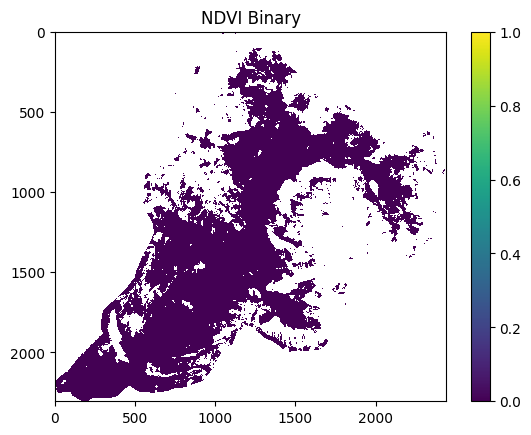

In [7]:
plt.imshow(ndvi_bin, interpolation='none', cmap='viridis', vmax = 1)
plt.colorbar()
plt.title('NDVI Binary')
plt.show()

In [9]:
def calc_rgb(ds):
    # Selecting RGB bands
    blue_band = ds.isel(band=0)
    green_band = ds.isel(band=1)
    red_band = ds.isel(band=2)
    nir_band = ds.isel(band=3)
    
    # normalize
    maxval = green_band.max().values
    minval = green_band.min().values
    red_norm = (red_band - minval) / (maxval - minval)
    green_norm = (green_band - minval) / (maxval - minval)
    blue_norm = (blue_band - minval) / (maxval - minval)
    green_norm = green_norm.where(red_norm <= 1,1)
    blue_norm = blue_norm.where(red_norm <= 1,1)
    red_norm = red_norm.where(red_norm <= 1,1)

    red_band = red_band.values
    green_band = green_band.values
    blue_band = blue_band.values
    nir_band = nir_band.values
    
    # Stack normalized bands to create RGB image
    rgb_image = np.stack([red_norm, green_norm, blue_norm], axis=-1)
    return red_band,green_band,blue_band,nir_band,rgb_image

def calc_false_color(ds):
    # Selecting RGB bands
    blue_band = ds.isel(band=0)
    green_band = ds.isel(band=1)
    red_band = ds.isel(band=2)
    nir_band = ds.isel(band=3)
    
    # normalize
    maxval = green_band.max().values
    minval = green_band.min().values
    red_norm = (red_band - minval) / (maxval - minval)
    green_norm = (green_band - minval) / (maxval - minval)
    blue_norm = (blue_band - minval) / (maxval - minval)
    nir_norm = (nir_band - minval) / (maxval - minval)
    green_norm = green_norm.where(red_norm <= 1,1)
    blue_norm = blue_norm.where(red_norm <= 1,1)
    red_norm = red_norm.where(red_norm <= 1,1)
    nir_norm = nir_norm.where(red_norm <= 1,1)

    red_band = red_band.values
    green_band = green_band.values
    blue_band = blue_band.values
    nir_band = nir_band.values
    
    # Stack normalized bands to create RGB image
    false_image = np.stack([nir_norm, red_norm, green_norm], axis=-1)
    return red_band,green_band,blue_band,nir_band,false_image 

In [ ]:
for dCount, direcc in enumerate(subdirecs):
    files = glob.glob(direcc + '/*/PSScene/*SR_clip.tif')
    if len(files) > 0:
        fname = files[0]
        ds = rxr.open_rasterio(fname, crs='EPSG:32611')
        red_band, green_band, blue_band, nir_band, rgb_image = calc_rgb(ds)
        red_band, green_band, blue_band, nir_band, false_image = calc_false_color(ds)
        
        # # Plot RGB image
        # plt.figure(figsize=(10, 10))
        # plt.imshow(rgb_image)
        # plt.title(f'RGB Image - {os.path.basename(fname)}')
        # plt.axis('off')
        # plt.show()
        
        # Plot False Color image
        plt.figure(figsize=(10, 10))
        plt.imshow(false_image)
        plt.imshow(ndvi_bin, alpha=0.5, cmap='Greys')
        plt.title(f'False Color Image - {os.path.basename(fname)}')
        plt.axis('off')
        plt.show()

In [16]:
import cmcrameri.cm as cmc

Text(0.5, 1.0, 'CHM Mask')

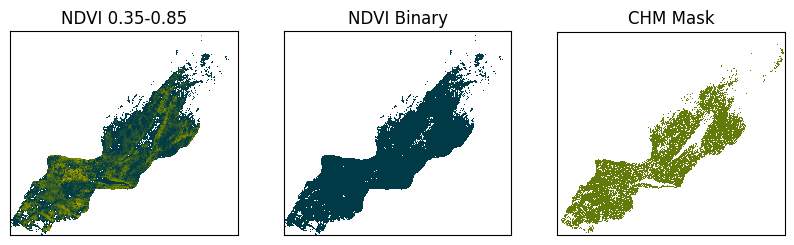

In [18]:
# problem 4 band NDVI map next to canopy heightmodel derived mask
fig,ax = plt.subplots(1,3,figsize=(10,10))
im = ax[0].imshow(binary_ndvi, interpolation = 'none', cmap=cmc.bamako,vmin = .45,vmax=.85)
im1 = ax[1].imshow(ndvi_bin, interpolation = 'none', cmap=cmc.bamako)#,vmin = -0.2,vmax=.2)
im2 = ax[2].imshow(chm_mask[0], interpolation='none',cmap=cmc.bamako,vmin = -.05,vmax=.05)
ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])
ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])
ax[0].set_title('NDVI 0.35-0.85')
ax[1].set_title('NDVI Binary')
ax[2].set_title('CHM Mask')


### Save canopy mask to tif

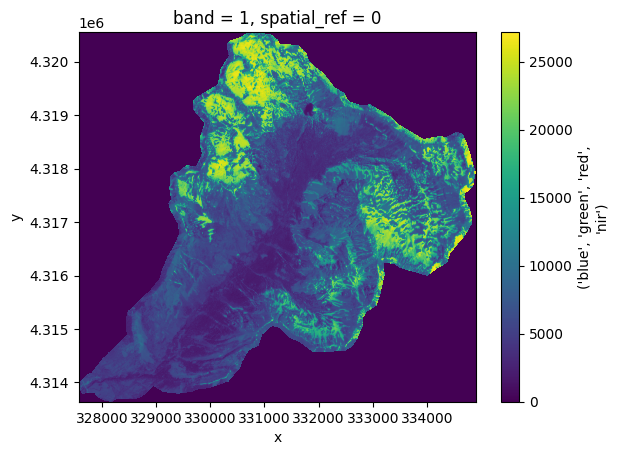

In [8]:
# ref_file = f'/data0/images/planet/emma/planet/{name}/' + '20230423_175100_99_242e/a514a5df-5610-45c4-8498-a774361cb492/PSScene/20230423_175100_99_242e_3B_AnalyticMS_SR_clip.tif' # BUDD
# ref_file = f'/data0/images/planet/emma/planet/{name}/'+'20230609_175435_13_242e/25d3618d-2f37-4c9e-8d67-c10e9d477081/PSScene/20230609_175435_13_242e_3B_AnalyticMS_SR_clip.tif' # DLNY
# ref_file  = data_direc + '20220403_174654_26_2451/68f7d4a5-cb41-4b0b-b0bb-1ce016f66730/PSScene/20220403_174654_26_2451_3B_AnalyticMS_SR_clip.tif' # BUDD rec
ref_file = data_direc + '20220609_173032_58_249d/6f0dba90-e90f-490d-936d-28c482343d1e/PSScene/20220609_173032_58_249d_3B_AnalyticMS_SR_clip.tif' #COPP
ref_file = rxr.open_rasterio(ref_file) #.rio.clip(basin.geometry.values, basin.crs)
mask = ref_file.values
mask = np.sum(mask,axis=0)
ref_file = ref_file.isel(band=0)
ref_file.values = mask
ref_file.plot()

In [19]:
print(binary_ndvi.shape)
print(ref_file.shape)

(2426, 2716)
(2426, 2716)


In [9]:
print(binary_ndvi.shape)
print(ref_file.shape)

(2305, 2441)
(2305, 2441)


In [10]:
# Save the classification result
ds_save = ref_file
ds_save.attrs['long_name'] = ('classification')
ds_save.values = binary_ndvi
ds_save.rio.to_raster(f'4b_15img_ndvi_30_85_{name}_notclipped.tif') #canopy
# ds_save.rio.to_raster(f'4b_15img_ndvi_open_{name}_notclipped.tif') #open not clipped
# ds_save.rio.to_raster(f'4b_15img_ndvi_open_{name}.tif') #open clipped
#ds.save.rio.to_raster(f'{name}_mask.tif')

In [ ]:
def run_ndvi_calculation_clipped(fname, basin, rgi_mask, wbd_mask):
        
        ds = rxr.open_rasterio(fname, crs = 'EPSG:32611').rio.clip(basin.geometry.values, basin.crs)
        ds.values = np.where(np.isnan(ds.values), 0, ds.values)

        ds = ds.rio.clip(rgi_mask.geometry,invert=True) #testing
        ds = ds.rio.clip(wbd_mask.geometry,invert=True) #testing
        print(ds.shape)
        arr = ds.values
        arr_sum = np.sum(arr,axis=0)

        # Extract the bands
        # blue = arr[0, :, :]
        # green = arr[1, :, :]
        red = arr[2, :, :]
        nir = arr[3, :, :]

        # Calculate NDVI
        ndvi = (nir - red) / (nir + red)

        return ndvi

chm_fn = '/home/etboud/projects/data/CHM/USCATB20140827_chm_3p0m.tif'

chm_rxr = rxr.open_rasterio(chm_fn,all_touched=False,drop=True, masked=True).rio.reproject('EPSG:32611', inplace=True).rio.clip(basin.geometry.values, all_touched = False,  drop=True)
chm_rxr.plot()

data_direc = f'/data0/images/planet/emma/planet/{name}/'
# specify the directories and the indices of which PS scenes to filter, if any
subdirecs = sorted([d for d in glob.glob(data_direc + str(year) + '*') if os.path.isdir(d)])[-15:]

# FOr NDVI 4 band processing
ref_date = datetime(year - 1, 10, 1).date()
ndvi_list = []
# rtvi_list = []
for dCount,direcc in enumerate(subdirecs):
        fname = glob.glob(direcc+'/*/PSScene/*SR_clip.tif')[0]
        ndvi_arr = run_ndvi_calculation_clipped(fname, basin, rgi_mask, wbd_mask)
        # Check if the shape is (4, 1627, 914)
        if ndvi_arr.shape == (2361, 2650):
                ndvi_list.append(ndvi_arr)
                


# Create a stacked data array for snow cover
stacked_ndvi = np.stack(ndvi_list, axis=0).astype(float)
fill_stacked_ndvi = fill_nodata(stacked_ndvi)
ndvi_mean = np.nanmean(fill_stacked_ndvi, axis=0)   

(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 1902, 1753)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2298)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)


(4, 2361, 2650)


/tmp/ipykernel_3700809/4189275032.py:19: RuntimeWarning: invalid value encountered in divide
  ndvi = (nir - red) / (nir + red)
/tmp/ipykernel_3700809/4189275032.py:43: RuntimeWarning: Mean of empty slice
  ndvi_mean = np.nanmean(fill_stacked_ndvi, axis=0)


/tmp/ipykernel_3700809/1231552778.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ndvi_values, color=colors[i], shade=True, ax=axes[i])
/tmp/ipykernel_3700809/1231552778.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ndvi_values, color=colors[i], shade=True, ax=axes[-1])
/tmp/ipykernel_3700809/1231552778.py:28: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(ndvi_values, color=colors[i], shade=True, ax=axes[i])
/tmp/ipykernel_3700809/1231552778.py:40: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.k

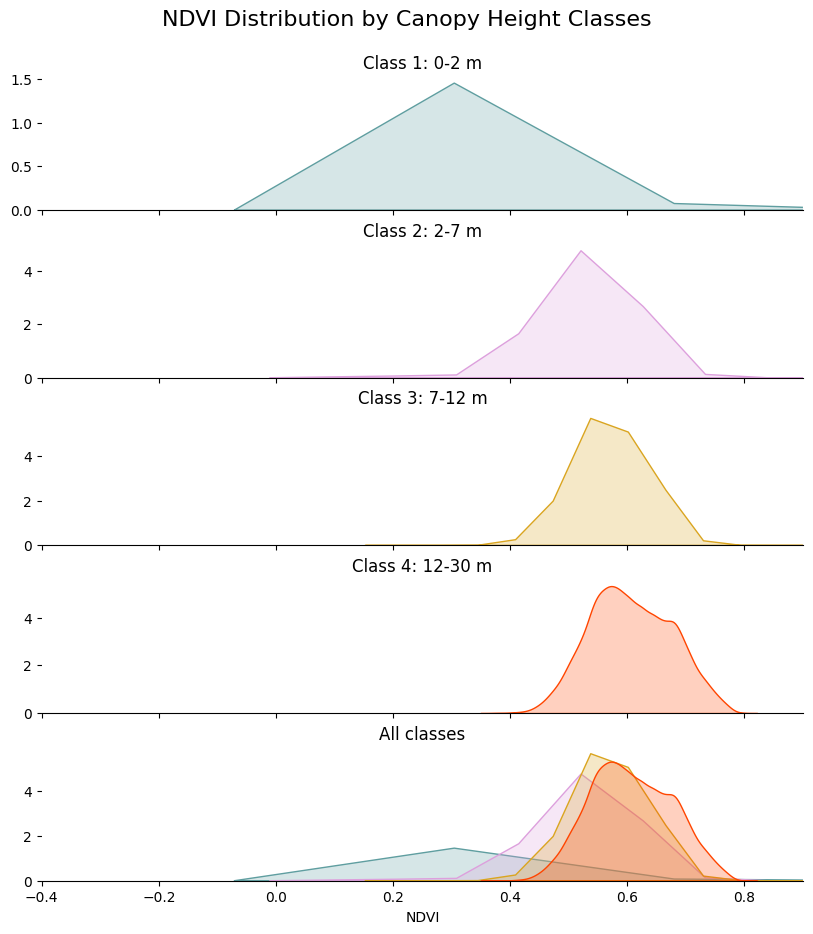

In [38]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Define height classes and colors
height_classes = [(0, 2), (2, 7), (7, 12), (12, 30)]
colors = ['cadetblue', 'plum', 'goldenrod', 'orangered'] #darkkhaki

# Create subplots: one subplot for each class plus one for "All classes"
num_classes = len(height_classes)
fig, axes = plt.subplots(num_classes + 1, 1, figsize=(8, 9), sharex=True)
#  change fontsize for entire plot
plt.rcParams.update({'font.size': 10})
# Plot each height class in its own subplot
for i, (min_val, max_val) in enumerate(height_classes):
    chm_range = chm_rxr.squeeze()
    ndvi_comp = ndvi_mean
    # Create a mask for the current height class in chm_range
    mask = (chm_range >= min_val) & (chm_range < max_val)
    
    # Apply the mask to ndvi_comp to get NDVI values within the current height range
    ndvi_values = ndvi_comp[mask]
    
    # Filter out NaN or zero values if necessary
    ndvi_values = ndvi_values[~np.isnan(ndvi_values) & (ndvi_values > 0)]
    
    # Plot KDE for the NDVI values of the current class on the respective subplot
    sns.kdeplot(ndvi_values, color=colors[i], shade=True, ax=axes[i])
    axes[i].set_title(f'Class {i+1}: {min_val}-{max_val} m')
    axes[i].set_ylabel('')
    axes[i].set_xlim(-0.4, 0.9)
    axes[i].spines['bottom'].set_color('black')
    axes[i].spines['top'].set_color('white') 
    axes[i].spines['right'].set_color('white')
    axes[i].spines['left'].set_color('white')

# Plot "All classes" on the last subplot
# all_ndvi_values = ndvi_comp
# all_ndvi_values = all_ndvi_values[~np.isnan(all_ndvi_values) & (all_ndvi_values > 0)]
    sns.kdeplot(ndvi_values, color=colors[i], shade=True, ax=axes[-1])
axes[-1].set_title('All classes')
axes[-1].set_ylabel('')

# Set x-axis label for the bottom subplot
axes[-1].set_xlabel('NDVI')
axes[-1].spines['bottom'].set_color('black')
axes[-1].spines['top'].set_color('white') 
axes[-1].spines['right'].set_color('white')
axes[-1].spines['left'].set_color('white')
# add main title and above the subplots

plt.suptitle('NDVI Distribution by Canopy Height Classes', fontsize=16,y=1.02)
# Adjust layout
plt.tight_layout(pad = .25)
plt.show()


In [8]:
from working_sca_funcs import validation_tif_binary
year='2022'
val_fns = glob.glob(f'/home/etboud/projects/data/aso/*Gunnison*{year}*3m.tif')
validation_tif_binary(val_fns, basin, year, name,EPSG)

Processing file: ASO_Gunnison_2022May18_snowdepth_3m
Saved binary TIFF to: /home/etboud/projects/data/aso/validation/COPP/ASO_Gunnison_2022May18_snowdepth_3m_binary.tif
Processing file: ASO_Gunnison_2022Apr21_snowdepth_3m
Saved binary TIFF to: /home/etboud/projects/data/aso/validation/COPP/ASO_Gunnison_2022Apr21_snowdepth_3m_binary.tif


# Basin BUFFERED MASK

In [8]:
basin

,ID,NAME,F_AREA,EBCz,PHz,km2,acres,lat,geometry
0,9,Copper,23666200.0,1,1,23.6662,5848.045,38.9856,"MULTIPOLYGON (((1369481.042 4364123.476, 13694..."


In [11]:
basin.crs

<Projected CRS: EPSG:26913>
Name: NAD83 / UTM zone 13N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 108°W and 102°W - onshore and offshore. Canada - Northwest Territories; Nunavut; Saskatchewan. United States (USA) - Colorado; Montana; Nebraska; New Mexico; North Dakota; Oklahoma; South Dakota; Texas; Wyoming.
- bounds: (-108.0, 28.98, -102.0, 84.0)
Coordinate Operation:
- name: UTM zone 13N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [12]:
name ='COPP'
fn = f'/home/etboud/projects/data/masks/4b_15img_ndvi_30_85_{name}_notclipped.tif'
# create a tif file with the same dimensions as the ndvi mask but all 1
# This is working 3/26
with rio.open(fn) as src:
    # Extract metadata from the existing raster
    width = src.width
    height = src.height
    crs = src.crs
    transform = src.transform
    dtype = src.dtypes[0]  # Get the data type of the raster
    nodata = src.nodata  # Get the NoData value (if any)

# Step 1: Create an empty raster with the same dimensions and other metadata
output_file = "/home/etboud/projects/data/masks/empty_raster.tif"  # Path to the new .tif file

# Create an empty array (initialized with zeros, or use np.nan if it's a floating point raster)
new_raster_data = np.ones((height, width), dtype=np.float32)  # Adjust dtype if needed

# Step 2: Write the new raster
with rio.open(output_file, 'w', driver='GTiff',
                    height=height, width=width,
                    count=1, dtype=new_raster_data.dtype,
                    crs=crs, transform=transform,
                    nodata=nodata) as dst:
    dst.write(new_raster_data, 1)  # Write the data to the raster (band 1)


empty = rxr. open_rasterio('/home/etboud/projects/data/masks/empty_raster.tif')
empty_clip = empty.rio.clip(basin.geometry.values, basin.crs, drop= False)
# where values are 0, make them np.nan
empty_clip.values = np.where(empty_clip.values==0, np.nan, empty_clip.values)
basin_buffered = empty_clip
basin_buffered.rio.to_raster(f'/home/etboud/projects/data/masks/{name}_mask_buffered.tif')


basin_mask = f'/home/etboud/projects/data/masks/{name}_mask_buffered.tif'
basin_mask = rxr.open_rasterio(basin_mask,  drop=True)
# For not buffered basin mask
basin_mask = basin_mask.rio.clip(basin.geometry.values, basin.crs)
basin_mask.values = np.where(basin_mask.values==0, np.nan, basin_mask.values)
basin_mask.rio.to_raster(f'/home/etboud/projects/data/masks/{name}_mask.tif')

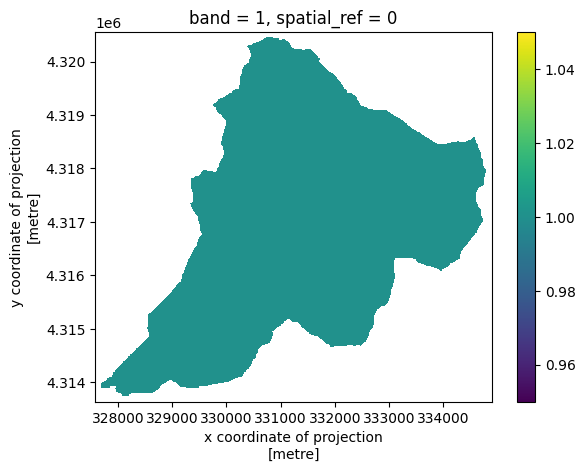

In [16]:
basin_buffered.plot()

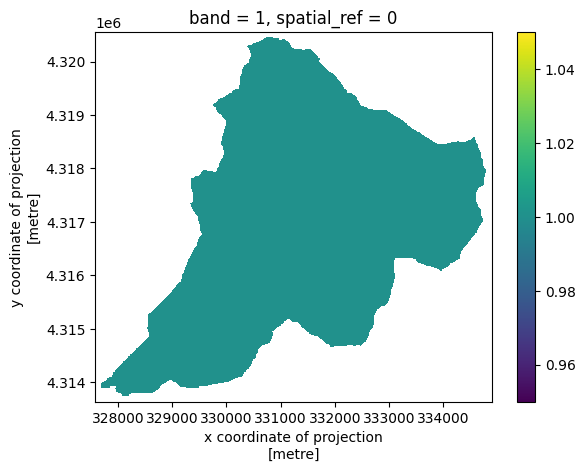

In [10]:
basin_buffered.plot()

In [28]:
from working_sca_funcs import validation_tif_binary
year = '2022'
tifs = glob.glob(f'/home/etboud/projects/data/aso/*Gunnison*{year}*3m.tif')
validation_tif_binary(tifs, basin, year, name)

Processing file: ASO_Gunnison_Mosaic_2022Apr21_snowdepth_3m
Saved binary TIFF to: /home/etboud/projects/data/aso/validation/COPP/ASO_Gunnison_Mosaic_2022Apr21_snowdepth_3m_binary.tif
Processing file: ASO_Gunnison_Mosaic_2022May18_snowdepth_3m
Saved binary TIFF to: /home/etboud/projects/data/aso/validation/COPP/ASO_Gunnison_Mosaic_2022May18_snowdepth_3m_binary.tif
